# 计算机网络体系结构第一次作业

## 实验设置

买卖的最小单位是一手，即 100 份。

### 买入

若忽略起点，买入费率为 0.038%

- 考虑买入证券交易费：过户费、佣金
- 过户费：按成交股票的金额 ×0.02‰收取，单位：元。双向收取（上海市场均收取）,过户费属于证券登记清算机构的收入
- 佣金：买卖双向收取，成交金额的 0.015%－0.3%，起点 5 元。此处取 0.018%

```python
deltaPositionValue = deltaPosition * stockToday["收盘"]
costBuy = deltaPositionValue*0.02/1e3 + max(deltaPositionValue*0.018/100, 5)
#self.cash -= deltaPosition * stockToday["收盘"]
self.cash = self.cash - deltaPositionValue - costBuy

#没有考虑self.cash不够，出现负数的情况
```

### 卖出

若忽略起点，买入费率为 0.043%

- 考虑买入证券交易费：印花税、过户费、佣金
- 印花税：单向收取，卖出成交金额的万分之五（5‱）印花税由政府收取
- 过户费：按成交股票的金额 ×0.02‰收取，单位：元。双向收取（上海市场均收取）,过户费属于证券登记清算机构的收入
- 佣金：买卖双向收取，成交金额的 0.015%－0.3%，起点 5 元。此处取 0.018%

```python
deltaPositionValue = pos["头寸"] * stockToday["收盘"]
costSell = deltaPositionValue*(1e-3 + 0.02/1e3) + max(deltaPositionValue*0.018/100, 5)
```


## 实验代码及说明


### 准备依赖


In [465]:
# !python -m pip install akshare matplotlib numpy pandas

In [466]:
import akshare as ak
import calendar
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import mpl
import os

### 准备实验数据


In [467]:
stockNameCodes: list[tuple[str, str]] = [
    ("512200", "房地产ETF"),
    ("513050", "中概互联网ETF"),
    ("510300", "沪深300ETF"),
    ("510050", "上证50ETF"),
    ("510500", "中证500ETF"),
    ("159915", "创业板ETF"),
    ("159902", "中小100ETF"),
    ("512010", "医药ETF"),
    ("512880", "证券ETF"),
    ("512580", "环保ETF"),
    ("159920", "恒生ETF"),
    ("510900", "H股ETF"),
    ("513500", "标普500ETF"),
    ("513100", "纳指ETF"),
    ("512660", "军工ETF")
]


def Preprocess(startDate: datetime.datetime, endDate: datetime.datetime):
    # 获取标的历史数据
    startDate = startDate - datetime.timedelta(days=365)

    allStockDaily: dict[str, pd.DataFrame] = {}
    path = f'data/{startDate.strftime("%Y")}-{endDate.strftime("%Y")}'
    if os.path.exists(path):
        print(f'使用已有数据({startDate.strftime("%Y")}-{endDate.strftime("%Y")})')
        for code, name in stockNameCodes:
            stockDaily = pd.read_csv(os.path.join(
                path, f"{name}_{code}.csv"), sep=',')
            stockDaily["日期"] = pd.to_datetime(stockDaily["日期"])
            stockDaily = stockDaily.set_index("日期", drop=False)

            allStockDaily[code] = stockDaily
        return allStockDaily

    os.makedirs(path)
    for i, (code, name) in enumerate(stockNameCodes):
        print(f"{i}. {name}({code}) 正在读取数据...")
        try:
            # stockDaily = ak.stock_zh_a_hist(
            stockDaily = ak.fund_etf_hist_em(
                symbol=code,
                period="daily",
                start_date=startDate.strftime("%Y%m%d"),
                end_date=endDate.strftime("%Y%m%d"),
                adjust="hfq",
            )
        except:
            print(
                f'{name}({code}): {startDate.strftime("%Y-%m-%d")}--{endDate.strftime("%Y-%m-%d")}读取失败!'
            )
            continue
        # print(stockDaily.columns)
        stockDaily = stockDaily[stockDaily["开盘"].notnull()]
        stockDaily["日期"] = pd.to_datetime(stockDaily["日期"])

        stockDaily.to_csv(os.path.join(
            path, f"{name}_{code}.csv"), index=False)
        stockDaily = stockDaily.set_index("日期", drop=False)

        allStockDaily[code] = stockDaily
    return allStockDaily


start = datetime.datetime(2017, 9, 1)
end = datetime.datetime(2024, 3, 14)
allStockDaily = Preprocess(start, end)
print(f"共有{len(allStockDaily)}个标的数据")

使用已有数据(2016-2024)
共有15个标的数据


Stock Name: 房地产ETF
Total Extra Cost: 644.6
Final: 615457.54 + 14.36 = 615471.9
Stock Name: 中概互联网ETF
Total Extra Cost: 665.95
Final: 665049.7100000001 + 14.94 = 665064.65
Stock Name: 沪深300ETF
Total Extra Cost: 774.75
Final: 918005.09 + 53.66 = 918058.75
Stock Name: 上证50ETF
Total Extra Cost: 775.71
Final: 920372.47 + 253.02 = 920625.49
Stock Name: 中证500ETF
Total Extra Cost: 773.47
Final: 915185.5 + 166.03 = 915351.53
Stock Name: 创业板ETF
Total Extra Cost: 720.4
Final: 791724.41 + 108.79 = 791833.2
Stock Name: 中小100ETF
Total Extra Cost: 722.31
Final: 796071.74 + 17.05 = 796088.79
Stock Name: 医药ETF
Total Extra Cost: 704.04
Final: 753655.39 + 137.17 = 753792.56
Stock Name: 证券ETF
Total Extra Cost: 771.84
Final: 911228.8 + 62.66 = 911291.46
Stock Name: 环保ETF
Total Extra Cost: 795.64
Final: 966560.9999999999 + 39.66 = 966600.66
Stock Name: 恒生ETF
Total Extra Cost: 699.79
Final: 743749.95 + 35.56 = 743785.51
Stock Name: H股ETF
Total Extra Cost: 671.03
Final: 676894.41 + 78.06 = 676972.47
Stock Name

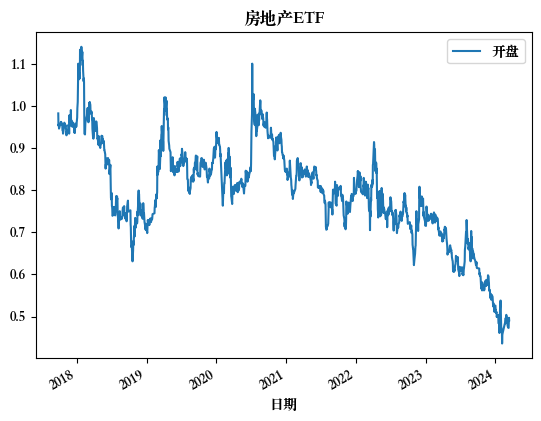

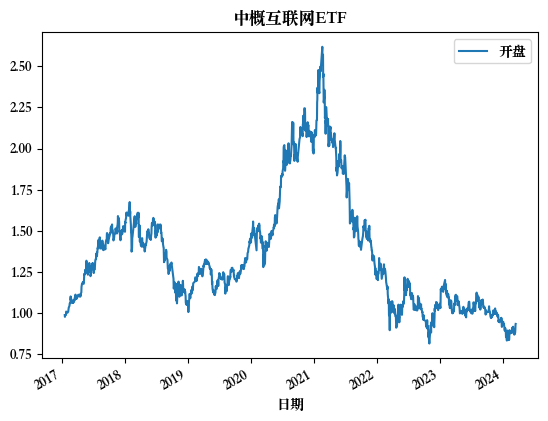

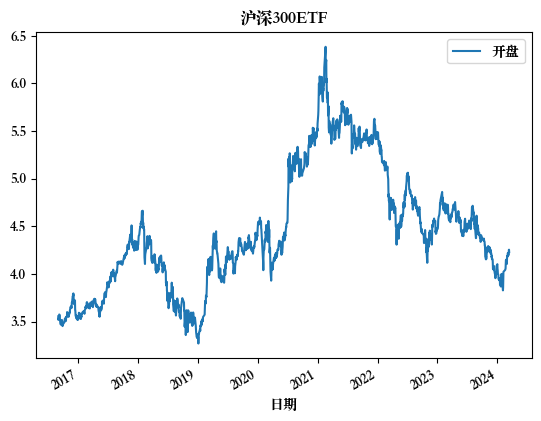

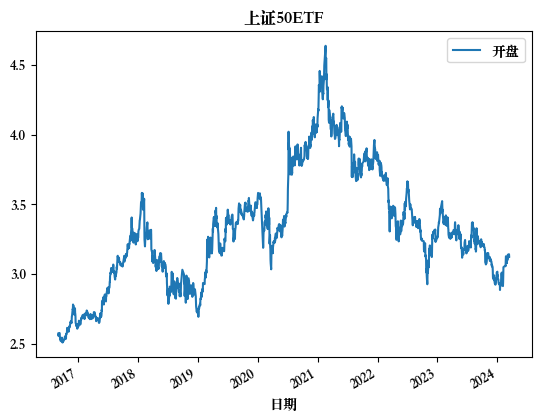

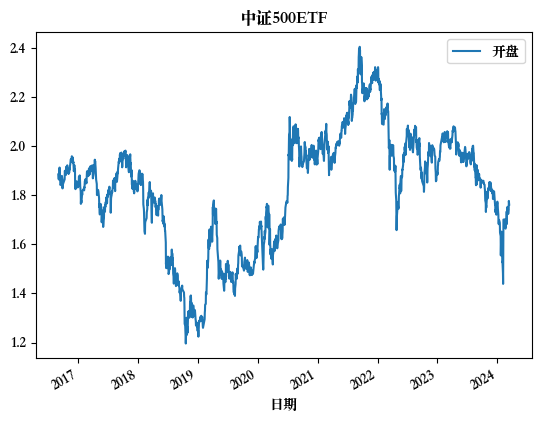

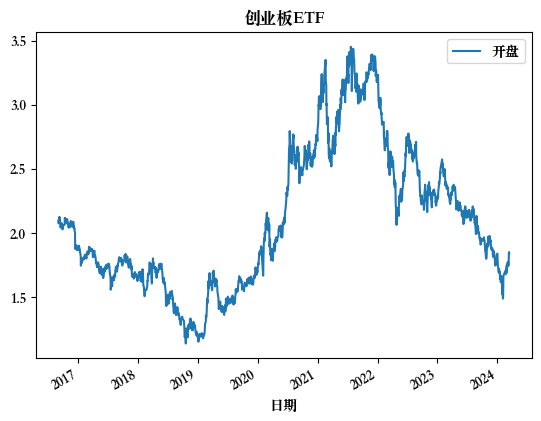

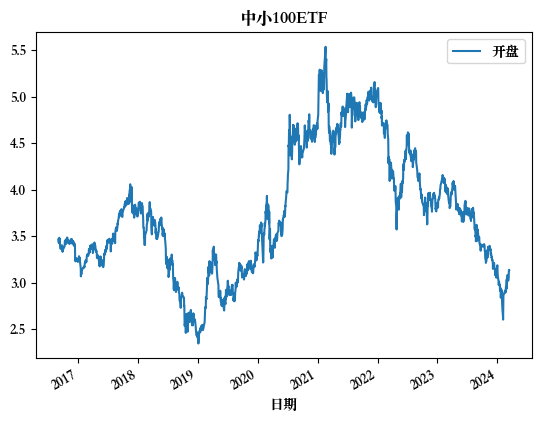

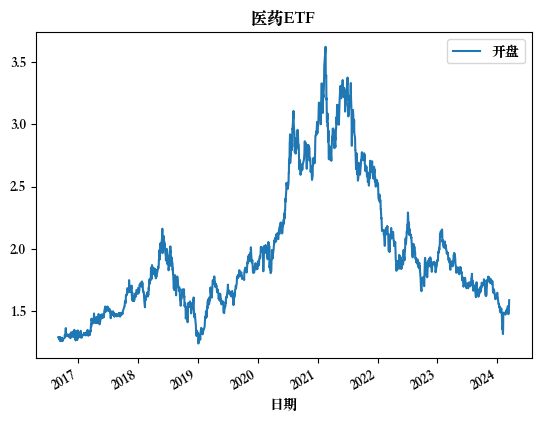

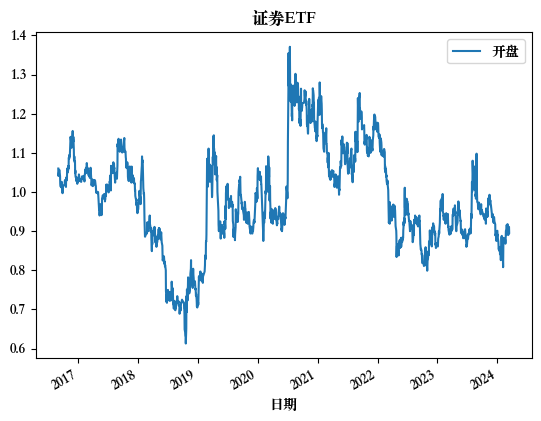

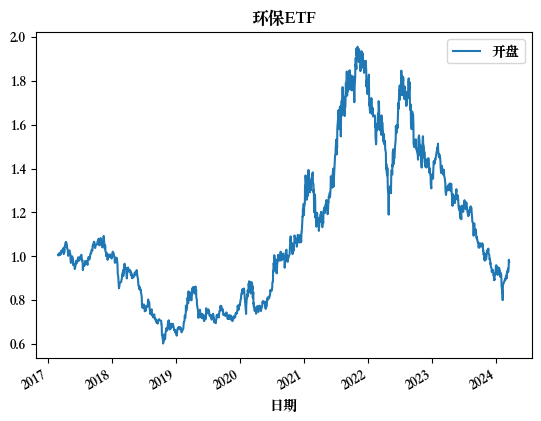

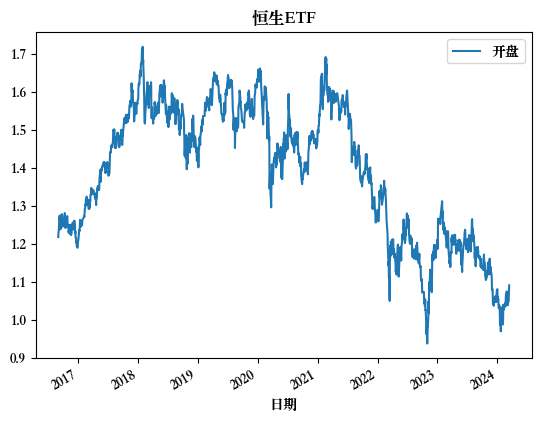

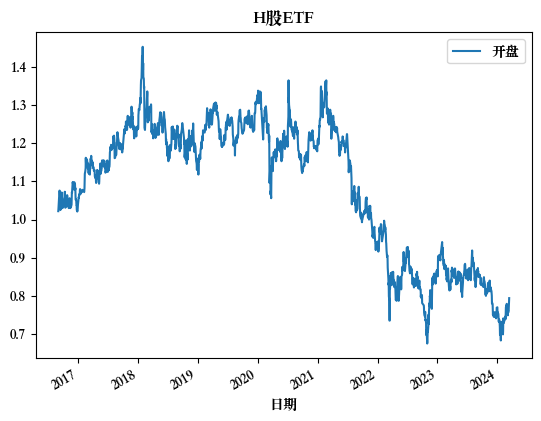

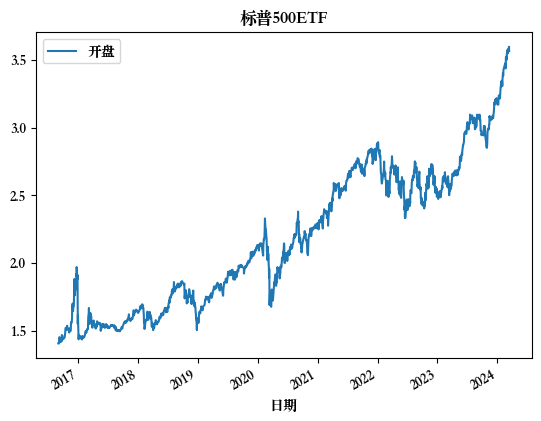

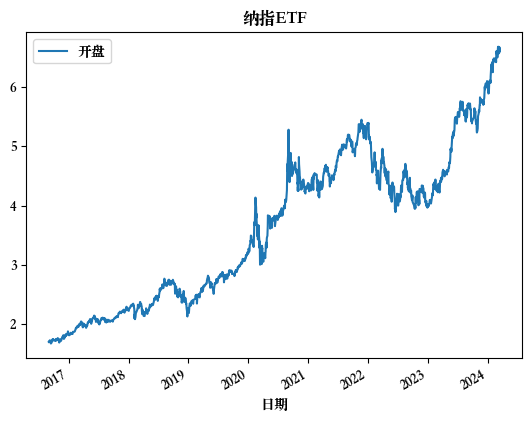

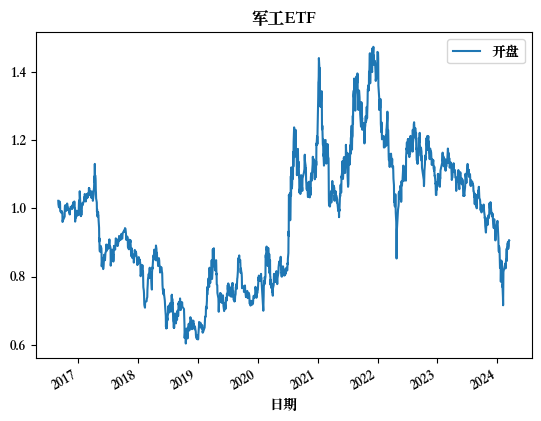

In [468]:
for stockNameCode in stockNameCodes:
    df = allStockDaily[stockNameCode[0]]
    # print(df.iloc[:, 0])
    # 设置显示中文字体
    mpl.rcParams["font.sans-serif"] = ["Songti SC"]

    p = df.plot(x='日期', y='开盘', title=stockNameCode[1])
    step = 90

    cur = 0
    periods = df.iloc[:, 0].size // step
    # 初始资金：一百万
    money = 1000000
    stocks = 0
    total_extra = 0

    # 日期
    d: list[datetime.datetime] = []
    # 已投入资金
    m: list[float] = []
    # 剩余资金
    n: list[float] = []
    # 总资产
    e: list[float] = []

    while periods > 0:
        # 本期准备使用的资金金额
        period_money = money/periods
        period_cost = period_money*38/1e5
        price: float = df.iloc[cur, 1]
        stock_count = (
            period_money-period_cost)//price//100
        stock_price = stock_count*100*price
        extra = round(stock_price*38/1e5, 2)
        money -= stock_price + extra
        money = round(money, 2)
        total_extra += extra
        assert stock_price*18 / \
            1e5 >= 5, f"{stock_price*18/1e5} >= 5，感觉浪费了，请调大一点投资周期（或增加投资资金）。"
        stocks += stock_count*100
        # print(cur, stocks, money)
        periods -= 1
        cur += step

    price: float = df.iloc[cur, 1]
    extra = round(stocks*price*43/1e5, 2)
    final = stocks*price-extra
    total_extra += extra
    total_extra = round(total_extra, 2)
    print(f"Stock Name: {stockNameCode[1]}")
    print(f"Total Extra Cost: {total_extra}")
    print(f"Final: {final} + {money} = {round(final+money,2)}")
    assert stocks*price*18 / \
        1e5 >= 5, f"{stocks*price*18/1e5} >= 5，感觉浪费了，请调大一点投资周期（或增加投资资金）。"